In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os
import cv2
import skimage.exposure
import pandas as pd

In [2]:
#DIR = os.path.join(HOME, 'programming', 'dk39')
DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/MD589'
INPUT = os.path.join(DIR, 'preps', 'CH1', 'thumbnail')
CLEANED = os.path.join(DIR, 'preps', 'CH1', 'cleaned')
MASKED = os.path.join(DIR, 'preps', 'masked')
files = sorted(os.listdir(INPUT))

In [211]:
# convert to hsv
def flood(img, colors):
    # convert to hsv
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

    # threshold using inRange
    if sum(colors) > 100:
        range1 = (80,80,80)
        range2 = (93,93,93)
    else:
        range1 = (0,0,0)
        range2 = (3,3,3)
        
    mask = cv2.inRange(hsv,range1,range2)
    mask = 255 - mask

    # apply morphology opening to mask
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # antialias mask
    mask = cv2.GaussianBlur(mask, (0,0), sigmaX=3, sigmaY=3, borderType = cv2.BORDER_DEFAULT)
    mask = skimage.exposure.rescale_intensity(mask, in_range=(127.5,255), out_range=(0,255))

    result = img.copy()
    result[mask==0] = colors
    return result



def place_image(img, file, max_width, max_height):
    zmidr = max_height // 2
    zmidc = max_width // 2
    startr = zmidr - (img.shape[0] // 2)
    endr = startr + img.shape[0]
    startc = zmidc - (img.shape[1] // 2)
    endc = startc + img.shape[1]

    start_bottom = img.shape[0] - 5
    bottom_rows = img[start_bottom:img.shape[0], :]
    avg = np.mean(bottom_rows)
    bgcolor = int(round(avg))
    bgcolor = 2**16-1
    new_img = np.zeros([max_height, max_width]) + bgcolor
    try:
        new_img[startr:endr, startc:endc] = img
    except:
        print('could not create new img', file)

    return new_img.astype('uint16')



def find_main_blob(stats, image):
    height, width = image.shape
    df = pd.DataFrame(stats)
    df.columns = ['Left', 'Top', 'Width', 'Height', 'Area']
    df['blob_label'] = df.index
    df = df.sort_values(by='Area', ascending=False)

    for row in df.iterrows():
        Left = row[1]['Left']
        Top = row[1]['Top']
        Width = row[1]['Width']
        Height = row[1]['Height']
        corners = int(Left == 0) + int(Top == 0) + int(Width == width) + int(Height == height)
        if corners <= 2:
            return row


def scale_and_mask(src, mask, epsilon=0.01):
    vals = np.array(sorted(src[mask > 10]))
    ind = int(len(vals) * (1 - epsilon))
    _max = vals[ind]
    #print('ind {} _max {}'.format(ind, _max))
    _range = 2 ** 16 - 1
    scaled = src * (45000. / _max)
    scaled[scaled > _range] = _range
    #scaled = scaled * (mask > 10)
    return scaled.astype('uint16'), _max


In [229]:
dels = os.listdir(CLEANED)
for d in dels:
    os.unlink(os.path.join(CLEANED, d))
dels = os.listdir(MASKED)
for d in dels:
    os.unlink(os.path.join(MASKED, d))

In [5]:
bads = ['0125.tif', '0118.tif']

In [230]:
def find_threshold(src):
    fig = matplotlib.figure.Figure()
    ax = matplotlib.axes.Axes(fig, (0,0,0,0))
    n,bins,patches=ax.hist(src.flatten(),160);
    del ax, fig
    min_point=np.argmin(n[:5])
    #print(n[:5])
    min_point = int(min(1, min_point))
    thresh=min_point*64000/660 + 1400
    return min_point, thresh

# get oriented for comparison
img_inputs = []
img_outputs = []
file_inputs = []
titles = []
masks = []
max_width = 1400
max_height = 900
for i, file in enumerate(tqdm(files)):
    infile = os.path.join(INPUT, file)
    src = io.imread(infile)
    img_inputs.append(src)
    
    start_bottom = src.shape[0] - 5
    bottom_rows = src[start_bottom:src.shape[0], :]
    avg = np.mean(bottom_rows)
    bgcolor = int(round(avg))
    lower = bgcolor - 10
    upper = bgcolor + 10
    bgmask = (src >= lower) & (src <= upper)
    #src[bgmask] = 0
    clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(16,16))
    h_src = clahe.apply(src)
    
    #src[src < 40] = 0
    
    min_value, threshold = find_threshold(h_src)   
    file_inputs.append(file)
    #threshold = 1500
    #print(min_value,threshold)
    ret, threshed = cv2.threshold(h_src, threshold, 255, cv2.THRESH_BINARY)
    threshed = np.uint8(threshed)
    connectivity = 4
    output = cv2.connectedComponentsWithStats(threshed, connectivity, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    row = find_main_blob(stats, h_src)
    blob_label = row[1]['blob_label']
    blob = np.uint8(labels == blob_label) * 255
    kernel10 = np.ones((10, 10), np.uint8)
    closing = cv2.morphologyEx(blob, cv2.MORPH_CLOSE, kernel10, iterations=5)
    scaled,_max=scale_and_mask(h_src,closing)
    scaled[scaled < 10] = 2**16-1
    
    #fixed = cv2.bitwise_and(src, closing)
    #fixed[fixed < 10] = bgcolor
    titles.append([min_value,threshold,bgcolor])
    img_outputs.append(scaled)
    outpath = os.path.join(CLEANED, file)    
    #cv2.imwrite(outpath, scaled.astype('uint16'))
    #closing = place_image(closing2, file, max_width, max_height)
    masks.append(closing)
    outpath = os.path.join(MASKED, file)    
    cv2.imwrite(outpath, closing.astype('uint8'))
print('Finished')

100%|██████████| 220/220 [01:03<00:00,  3.46it/s]

Finished


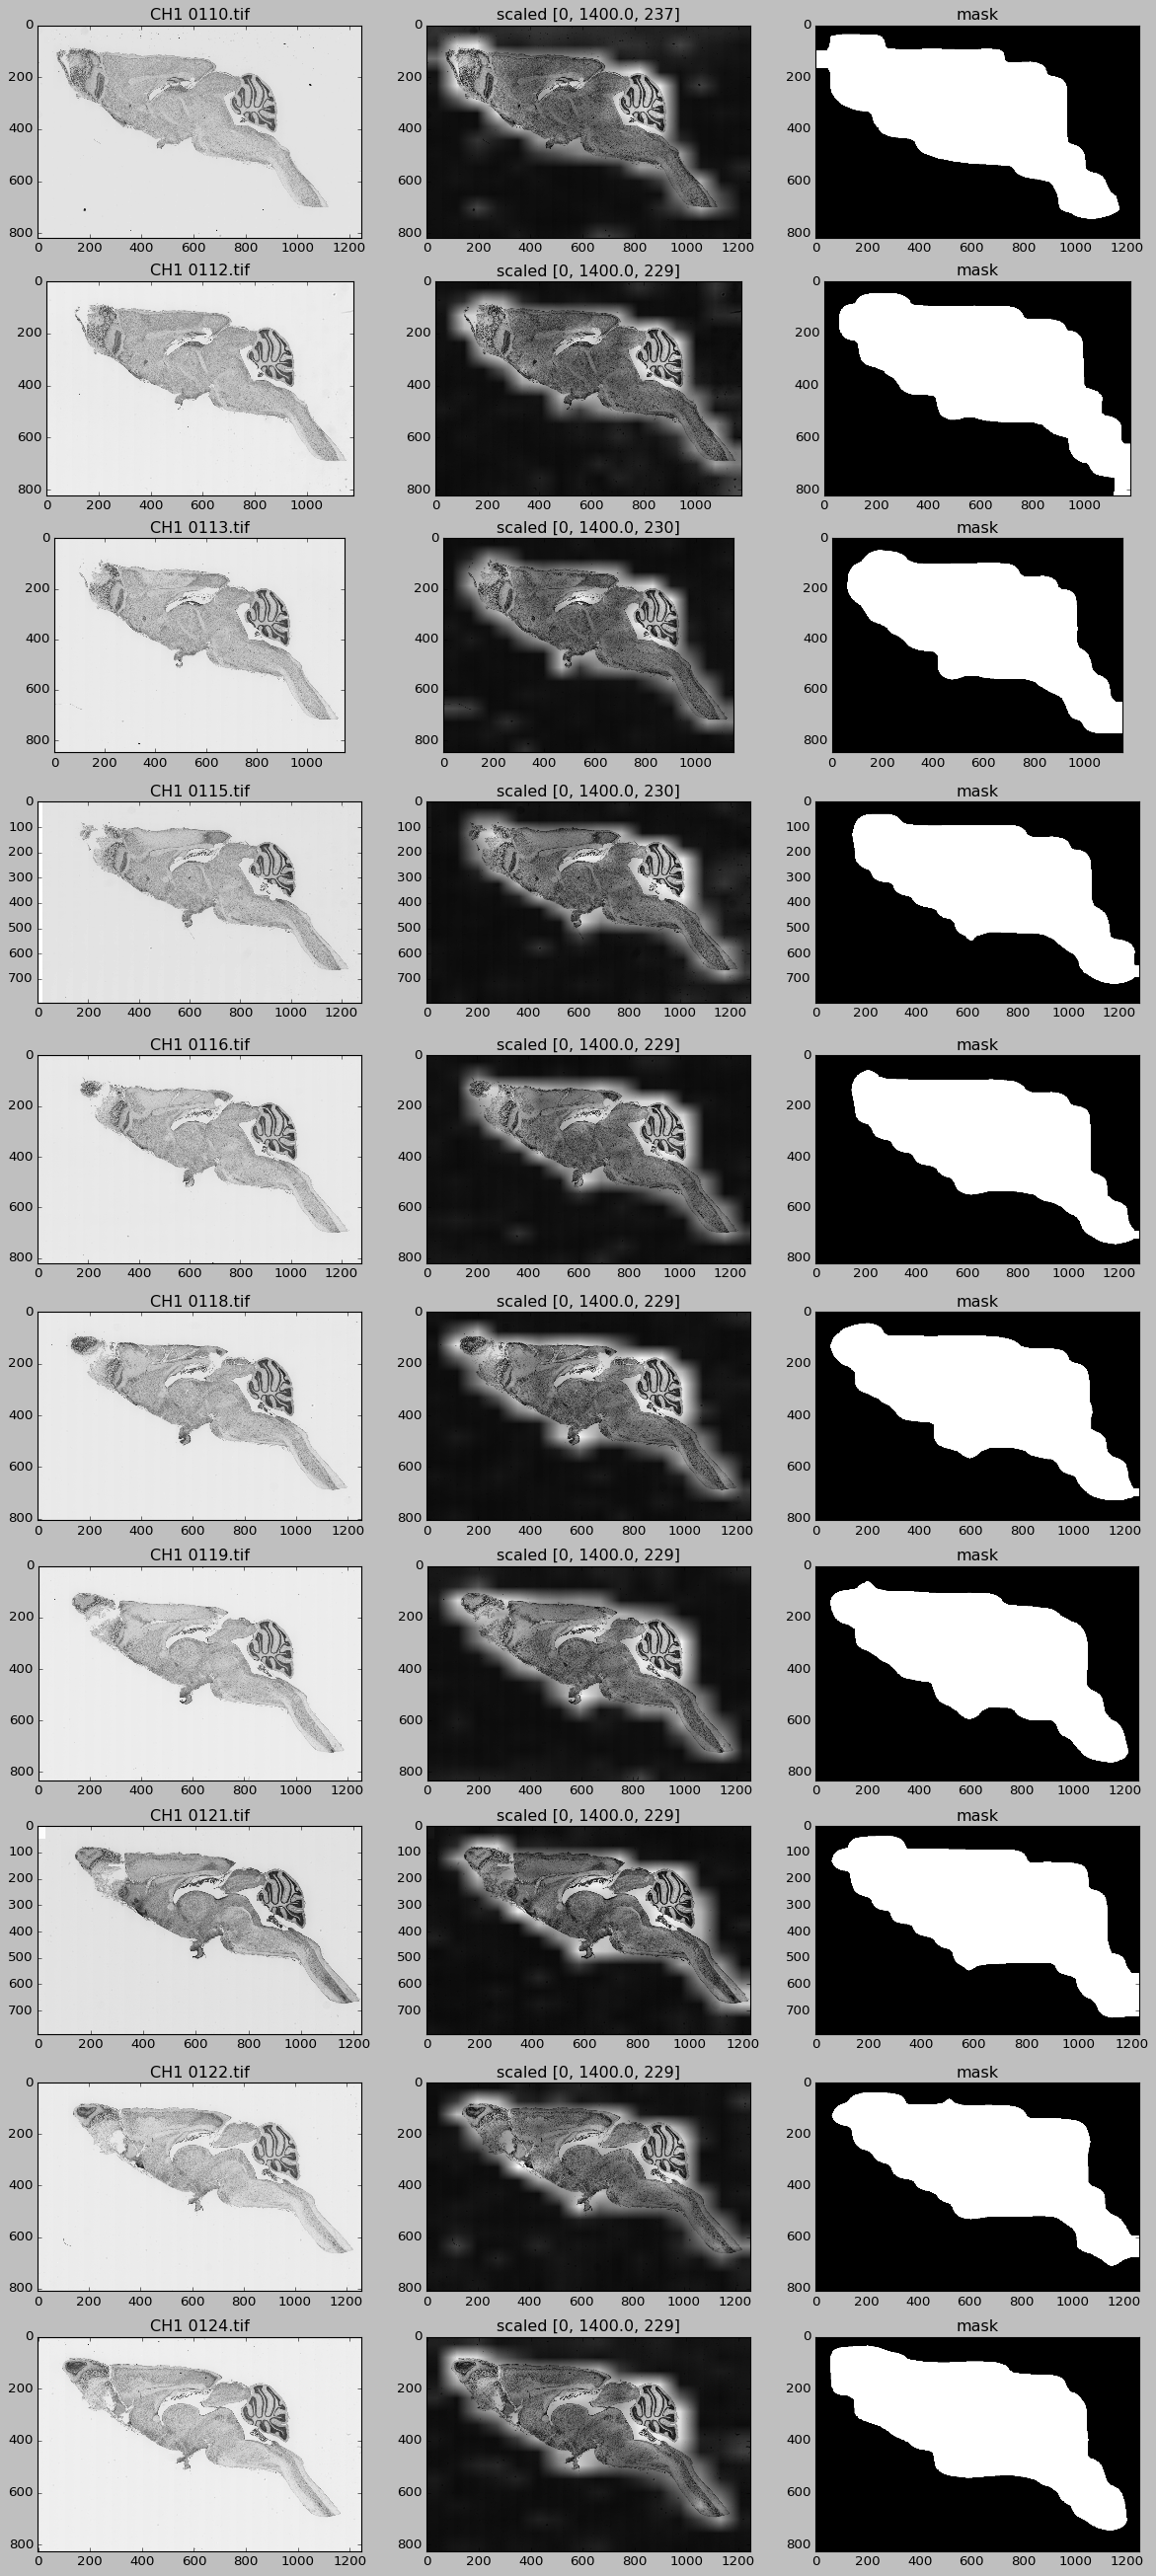

In [228]:
start, finish = (0,10)
#displays = masks[start:finish]
dins = img_inputs[start:finish]
douts = img_outputs[start:finish]
dmasks = masks[start:finish]
dtitles = titles[start:finish]
names = file_inputs[start:finish]

fig, ax = plt.subplots(nrows=len(names), ncols=3, sharex=False)
plt.style.use('classic')
i = 0
for filein,fileout, mask,name,title in zip(dins, douts, dmasks, names, dtitles):
    ax[i,0].set_title('CH1 {}'.format(name))
    ax[i,0].imshow(filein, cmap="gray")
    ax[i,1].set_title('scaled {}'.format(str(title)))
    ax[i,1].imshow(fileout, cmap="gray")
    ax[i,2].set_title('mask')
    ax[i,2].imshow(mask, cmap="gray")

    i += 1
# swap the 10 and the six below if the images are wider than height
fig.set_size_inches(np.array([18, 4 * len(names)]), forward=True)
plt.show()

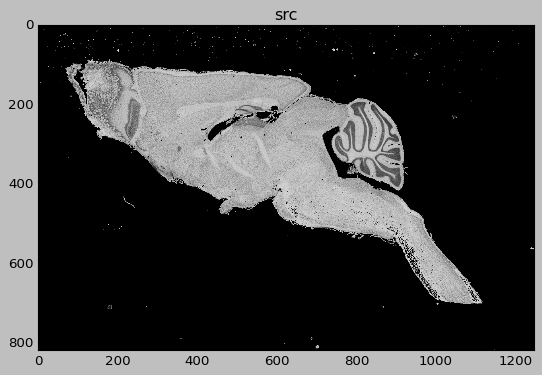

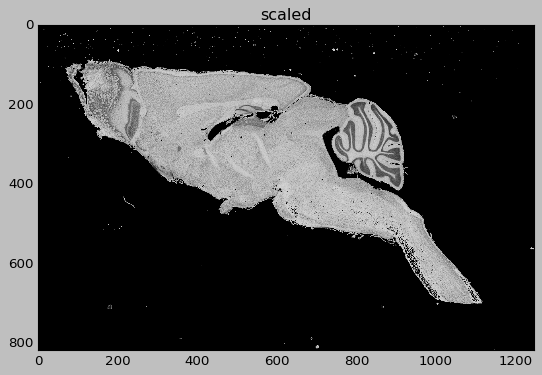

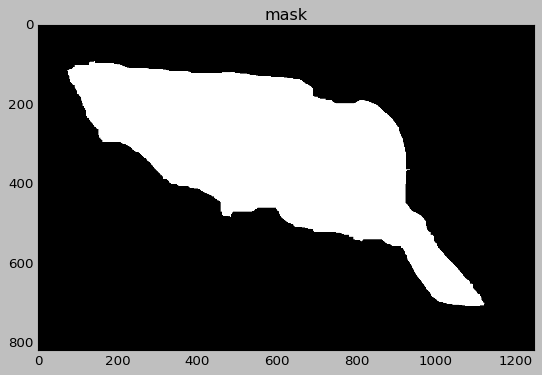

In [30]:
infile = os.path.join(INPUT, '0110.tif')
src = io.imread(infile)
#src = src[:, :, 0]
#clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(16,16))
#src = clahe.apply(src)
start_bottom = src.shape[0] - 5
bottom_rows = src[start_bottom:src.shape[0], :]
avg = np.mean(bottom_rows)
bgcolor = int(round(avg))
lower = bgcolor - 20
upper = bgcolor + 20
bgmask = (src >= lower) & (src <= upper)
src[bgmask] = 0




min_value, threshold = find_threshold(src)
threshold = 100
ret, threshed = cv2.threshold(src, threshold, 255, cv2.THRESH_BINARY)
threshed = np.uint8(threshed)
connectivity = 4
output = cv2.connectedComponentsWithStats(threshed, connectivity, cv2.CV_32S)
num_labels = output[0]
labels = output[1]
stats = output[2]
centroids = output[3]
row = find_main_blob(stats, src)
#print(row)
blob_label = row[1]['blob_label']
start_bottom = src.shape[0] - 5
bottom_rows = src[start_bottom:src.shape[0], :]
avg = np.mean(bottom_rows)
bgcolor = int(round(avg))

blob = np.uint8(labels == blob_label) * 255
kernel10 = np.ones((10, 10), np.uint8)
mask = cv2.morphologyEx(blob, cv2.MORPH_CLOSE, kernel10, iterations=5)
scaled, _max = scale_and_mask(src, mask)

#scaled[scaled < 10] = 2**16-1


plt.figure()
plt.rcParams.update({'figure.figsize': [8, 6]})
plt.title('src')
plt.imshow(src, cmap='gray')
plt.show()

plt.figure()
plt.rcParams.update({'figure.figsize': [8, 6]})
plt.title('scaled')
plt.imshow(scaled, cmap='gray')
plt.show()

plt.figure()
plt.rcParams.update({'figure.figsize': [8, 6]})
plt.title('mask')
plt.imshow(mask, cmap='gray')
plt.show()
